
# 📘 Chapter 6: K‑Nearest Neighbors (KNN)

This chapter presents the **K‑Nearest Neighbors (KNN)** algorithm for classification and regression. The exposition follows a third-person textbook style with clear LaTeX and runnable examples.



## 6.1 Intuition

KNN predicts the output for a new input by looking at the **\(K\)** most similar training examples (the *neighbors*) and aggregating their labels.

- **Classification:** majority vote among neighbors.  
- **Regression:** average of neighbor targets.

KNN is **instance-based** (lazy). No explicit parametric training occurs; prediction uses the stored dataset.



## 6.2 Distance Metrics

Similarity is measured by a distance function \(d(x, x')\). Common choices:

- **Euclidean distance**  
$$
d_{\ell_2}(x, x') \;=\; \sqrt{ \sum_{j=1}^{d} \big(x_j - x'_j\big)^2 }.
$$

- **Manhattan distance**  
$$
d_{\ell_1}(x, x') \;=\; \sum_{j=1}^{d} \big|x_j - x'_j\big|.
$$

- **Minkowski distance** (general form)  
$$
d_p(x, x') \;=\; \left( \sum_{j=1}^{d} \big|x_j - x'_j\big|^p \right)^{\!1/p}.
$$

**Important:** Feature **scaling** strongly affects distances; standardization is often beneficial.



## 6.3 Algorithm

Given a query point $(x_\star$):

1. Compute distances $(d(x_\star, x^{(i)})$) to all training points.  
2. Select the $(K$) closest neighbors.  
3. **Classification:** predict the most frequent label among neighbors.  
   **Regression:** predict the mean of neighbor targets.

A weighted variant uses weights $(w_i \propto 1 / d(x_\star, x^{(i)})$) (or a kernel) to give closer neighbors more influence.



## 6.4 Hyperparameters and Choices

- **\(K\)**: number of neighbors (odd values reduce ties in binary classification).  
- **Distance metric**: Euclidean is common; others may suit specific data.  
- **Weighting**: uniform vs. distance‑weighted.  
- **Feature scaling**: standardization/normalization is recommended.  
- **Search structure**: brute force, KD‑tree, or Ball‑tree (scikit‑learn picks based on data).



## 6.5 Computational Considerations

- **Training cost:** negligible (storing data).  
- **Prediction cost:** \(O(nd)\) per query with brute force, where \(n\) is the number of training points and \(d\) the dimension.  
- **Memory cost:** stores the entire training set.



## 6.6 Pros and Cons

**Pros**  
- Simple, non‑parametric, competitive on well‑behaved data.  
- Naturally handles multi‑class classification.  

**Cons**  
- Sensitive to the scale of features and irrelevant features.  
- Prediction can be slow for large datasets.  
- Performance degrades in high dimensions (curse of dimensionality).



## 6.7 Hands‑On A: KNN Classification on Iris (with Scaling and Model Selection)

This example performs standardization, tunes \(K\) via cross‑validation on the training set, and evaluates on a held‑out test set.


In [1]:

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Iris
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline: scale -> KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Smaller but solid grid; avoids heavy CPU/memory + Windows worker issues
param_grid = {
    'knn__n_neighbors': list(range(1, 16)),   # 1..15
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]                          # Manhattan or Euclidean
}

# IMPORTANT: n_jobs=1 prevents TerminatedWorkerError on some Windows/conda setups
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=1,                  # <- key change
    verbose=1,
    error_score='raise'
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy: %.4f" % grid.best_score_)

# Evaluate on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Test accuracy: %.4f" % accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Best CV accuracy: 0.9667
Test accuracy: 0.9333

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30


Confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]



## 6.8 Hands‑On B: The Effect of Scaling

This snippet compares KNN accuracy **with** and **without** standardization.


In [2]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Without scaling
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(X_train, y_train)
acc_raw = accuracy_score(y_test, knn_raw.predict(X_test))

# With scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_s, y_train)
acc_scaled = accuracy_score(y_test, knn_scaled.predict(X_test_s))

print("Accuracy without scaling:", acc_raw)
print("Accuracy with scaling   :", acc_scaled)


Accuracy without scaling: 1.0
Accuracy with scaling   : 0.9333333333333333



## 6.9 Hands‑On C: KNN Regression (Synthetic Data)

The following example fits KNN **regression** on a noisy 1‑D function and contrasts different \(K\) values.


K=1  MSE=0.0652  R^2=0.8917


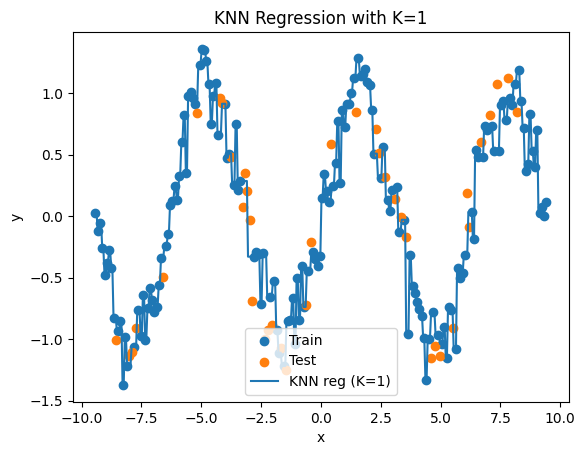

K=5  MSE=0.0489  R^2=0.9189


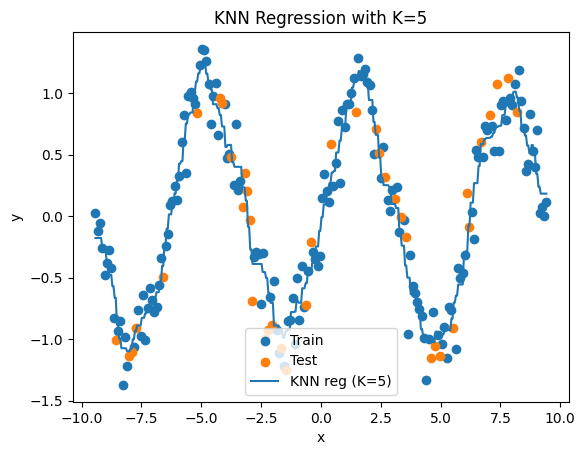

K=15  MSE=0.0715  R^2=0.8814


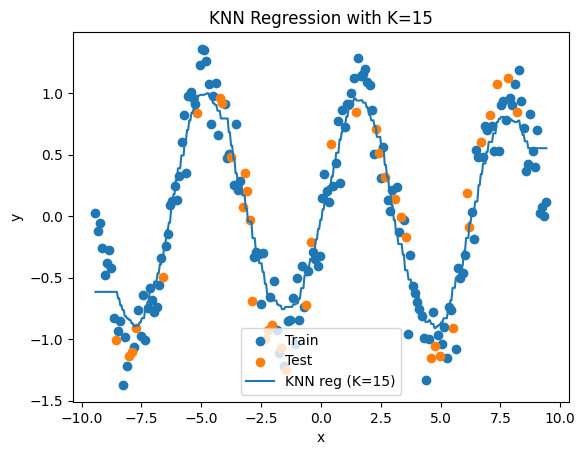

K=35  MSE=0.2665  R^2=0.5577


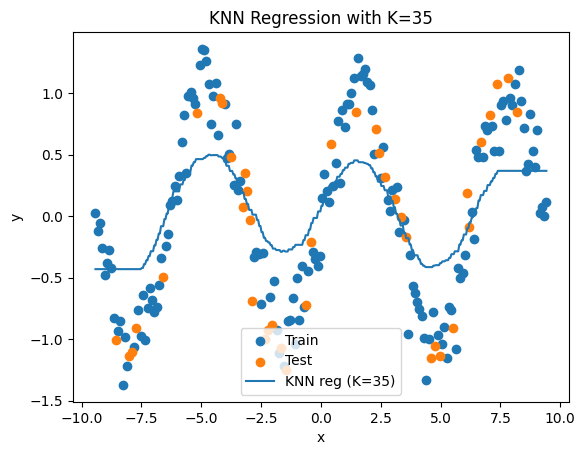

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Synthetic data: y = sin(x) + noise
rng = np.random.default_rng(0)
Xr = np.linspace(-3*np.pi, 3*np.pi, 200).reshape(-1, 1)
yr_true = np.sin(Xr).ravel()
noise = rng.normal(0, 0.2, size=yr_true.shape)
yr = yr_true + noise

Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.2, random_state=42)

def fit_and_plot(k):
    model = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    model.fit(Xr_tr, yr_tr)
    yr_pred = model.predict(Xr_te)
    print(f"K={k}  MSE={mean_squared_error(yr_te, yr_pred):.4f}  R^2={r2_score(yr_te, yr_pred):.4f}")

    # Plot predictions on a dense grid
    xx = np.linspace(Xr.min(), Xr.max(), 400).reshape(-1, 1)
    yy = model.predict(xx)
    plt.figure()
    plt.scatter(Xr_tr, yr_tr, label="Train")
    plt.scatter(Xr_te, yr_te, label="Test")
    plt.plot(xx, yy, label=f"KNN reg (K={k})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(f"KNN Regression with K={k}")
    plt.show()

for k in [1, 5, 15, 35]:
    fit_and_plot(k)


## 6.10 Summary

- KNN predicts using labels of the \(K\) nearest training points, with majority vote (classification) or averaging (regression).  
- Distances (Euclidean/Manhattan) and **scaling** play a central role.  
- \(K\), weighting, and distance metric are the main hyperparameters.  
- KNN is simple and often effective, but prediction can be slow and high‑dimensional settings are challenging.

